<a href="https://colab.research.google.com/github/tomdyer10/fake_news/blob/master/FastAI%2BBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Majority of code is inspired by - https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2

Goal of training a BERT model on a fake news dataset with the FastAI toolkit available on top, ie integrating transformers and fast ai library.

In [1]:
!pip install transformers

     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 15.0MB/s 
     |████████████████████████████████| 890kB 22.0MB/s 
     |████████████████████████████████| 3.8MB 24.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5f46a23a7db67f94db0916fde71c87c257fa881029aae39afa032f5f2a681c11
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np


import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig

In [0]:
model_type = 'bert'
pretrained_model_name='bert-base-uncased'

model_class = BertForSequenceClassification
tokenizer_class = BertTokenizer
config_class = BertConfig

Create custome tokenizer to fit over the fast ai library

In [4]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        #halving max_seq_len to reduce strain on colab gpu
        self.max_seq_len = 350
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        tokens = [CLS] + tokens + [SEP]
        return tokens
        
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [5]:
transformer_tokenizer.max_len

512

Notes from blog post - Be Careful:

1. As we are not using RNN, we have to limit the sequence length to the model input size.

2. Most of the models require special tokens placed at the beginning and end of the sequences.

3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Other model-specific rules have been removed from my code above - see full article here for them - https://towardsdatascience.com/fastai-with-transformers-bert-roberta-xlnet-xlm-distilbert-4f41ee18ecb2

Bert expects text input in the format:

`BERT: [CLS] + tokens + [SEP] + padding`

Create custom numericalizer:

Create a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions.

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

Create our custom processor with the tokenizer and numericalizer defined above

In [0]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

Load Data and create custom data bunch

(only loading train set for now to test)

In [0]:
path = 'drive/My Drive/fake_news_1/data/train.csv'
df = pd.read_csv(path)
df = df.dropna()

In [9]:
df.shape

(18285, 5)

As I am running on google colab free GPU, it will not allow me to run with whole dataset - running with sample of 10,000 items.

In [0]:
df = df.sample(n=10000)

In [11]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
seed = 42
bs=12

databunch = (TextList.from_df(df, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [12]:
databunch.show_batch()

text,target
"[CLS] an armed dakota access security contractor confronted indigenous water protector ##s fighting the construction of an oil pipeline in north dakota . he had an assault rifle , which he pointed at the water protector ##s , and he wore a banda ##na over his face . he was arrested by the bureau of indian affairs police and later released without charge . in video aired by “ democracy",1
"[CLS] as a th ##rong of chinese reporters crowded in front of him , jeremy lin briefly cast his eyes toward the distant skyline of manhattan , the birthplace of lin ##san ##ity . it has been four years since mr . lin seemed to inspire new yorker ##s and asian ##s around the world with his mystical , mythical string of performances with the new york knicks . but",0
"[CLS] smaller lava ##tori ##es are helping airlines to add extra seats to new and existing aircraft for more profit , but some passengers — if they can get into the bathrooms — say they are being short ##chang ##ed . the continuing installation of smaller and rec ##on ##fi ##gur ##ed bathrooms , which began in late 2013 , has led to complaints about safety issues , say travelers",0
"[CLS] by jameson parker election 2016 , politicians be ##ha ##ving badly , politics november 4 , 2016 ‘ is he having a stroke ? ’ : hu ##ck ##abe ##e calls trump a ‘ car wreck , ’ freaks out when people laugh at him it was a good morning for ben carson . no longer can it be said that he is donald trump ’ s very worst",1
"[CLS] the inmates were just starting their day on july 6 when dozens of corrections officers burst into their dormitory , shouting for everyone to get down on the floor . the raid at correctional facility , outside ut ##ica , n . y . officials said , was a surprise search for weapons made urgent after a bloody injury to a guard three days earlier . but over the",0


Target Labels:

1 - unreliable news article

0 - reliable news article

Define model so only returns logits 

In [0]:
class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

In [14]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2

transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Create learner with our custom transformer and AdamW optimizer

In [0]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy])

In [16]:
print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [17]:
learner.model

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

List layers to allow splitting of model.

In [0]:
list_layers = [learner.model.transformer.bert.embeddings,
               learner.model.transformer.bert.encoder.layer[0],
               learner.model.transformer.bert.encoder.layer[1],
               learner.model.transformer.bert.encoder.layer[2],
               learner.model.transformer.bert.encoder.layer[3],
               learner.model.transformer.bert.encoder.layer[4],
               learner.model.transformer.bert.encoder.layer[5],
               learner.model.transformer.bert.encoder.layer[6],
               learner.model.transformer.bert.encoder.layer[7],
               learner.model.transformer.bert.encoder.layer[8],
               learner.model.transformer.bert.encoder.layer[9],
               learner.model.transformer.bert.encoder.layer[10],
               learner.model.transformer.bert.encoder.layer[11],
               learner.model.transformer.bert.pooler]



In [19]:
learner.split(list_layers)

Learner(data=TextClasDataBunch;

Train: LabelList (9000 items)
x: TextList
[CLS] fr ##eit ##ag , 4 . november 2016 u ##bri ##ge wrestler uber ##leg ##en , wan ##n si ##e tim wi ##ese end ##lich sage ##n sol ##len , das ##s all ##es ab ##ges ##pro ##chen ist munchen ( d ##po ) - fr ##uh ##er oder spat ##er wi ##rd tim wi ##ese die wah ##rh ##eit er ##fa ##hre ##n mu ##ssen . doc ##h no ##ch rats ##el ##n seine wrestler - ko ##lle ##gen , wan ##n si ##e den ex - national ##tor ##wart am best ##en wi ##ssen lass ##en sol ##len , das ##s se ##in si ##eg bei seine ##m debut als prof ##i - wrestler in der mu ##nch ##ner olympia ##hall ##e von vo ##rn ##her ##ein ab ##ges ##pro ##chen war . " tim hat sic ##h so ins ze ##ug gel ##eg ##t fur seine ##n er ##sten kam ##pf , da will ich ec ##ht nic ##ht der se ##in , der i ##hm jet ##z ##t er ##kla ##ren mu ##ss , das ##s un ##ser ##e ge ##gne ##r abs ##ich ##tl ##ich ve ##rl ##ore ##n ha ##ben und all ##e au ##ße ##r i ##hm vo ##rh ##er be ##sche

Train by progressively unfreezing the model

In [0]:
learner.freeze_to(-1)

In [21]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


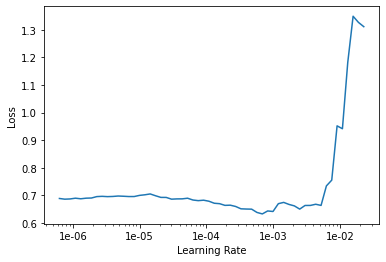

In [22]:
learner.recorder.plot()

In [23]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.278047,0.236530,0.906000,01:52


In [24]:
learner.fit_one_cycle(3,max_lr=2e-03,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.298113,0.591487,0.809000,01:52
1,0.306755,0.200342,0.920000,01:53
2,0.238068,0.190933,0.926000,01:53


87% after 4 minutes total training time and on only 1800 training samples is pretty strong performance. This would place us 9th in the Kaggle competition (winner is 98.598% accuracy)

In [0]:
learner.unfreeze()
learner.freeze_to(-2)

In [27]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


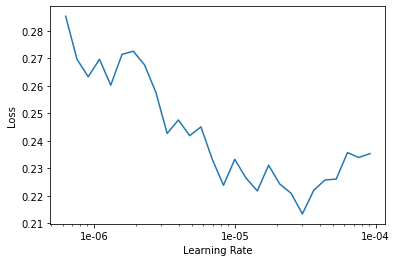

In [28]:
learner.recorder.plot()

In [29]:
learner.fit_one_cycle(3,max_lr=3e-05,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.079428,0.060995,0.980000,02:06
1,0.029964,0.025607,0.993000,02:06
2,0.013123,0.025750,0.995000,02:06


Model accuracy is already above the top kaggle result on training dataset, having only trained over the final bert layer.

In [0]:
learner.save('model_1')

In [0]:
path_to_gdrive = '../drive/My Drive/fake_news_1/models/'
learner.save(path_to_gdrive + 'fastai+bert_1')

In [0]:
learner.unfreeze()
learner.freeze_to(-4)

In [34]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


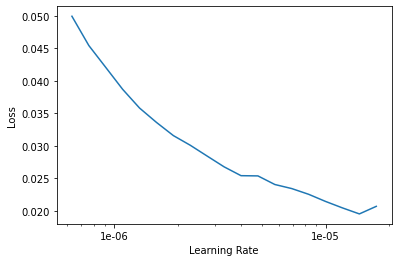

In [35]:
learner.recorder.plot()

In [37]:
learner.fit_one_cycle(2,max_lr=1e-06,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.018909,0.024160,0.993000,02:38
1,0.016711,0.023170,0.995000,02:38


No improvement with additional unfreezing and training, however 99.5% would place us top in the kaggle competition on this dataset.

In [0]:
learner.freeze()
learner.save(path_to_gdrive + 'fastai+bert_2')

Now to test model performance on test data...

*Note - I forgot to add this test set to my fast ai databunch initially, with hindsight I would have created 2 dataframes and added a df_test to my original databunch*

In [0]:
path = 'drive/My Drive/fake_news_1/data/train.csv'
df_test = pd.read_csv(path)

In [0]:
train_ids = np.array(df['id'])
df_test = df_test[~df_test.id.isin(train_ids)]
df_test = df_test.dropna()

In [52]:
df_test.head(3)

,id,title,author,text,label
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0


In [53]:
data_test = (TextList.from_df(df_test, cols='text', processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'label')
             .databunch(bs=24, pad_first=pad_first, pad_idx=pad_idx))

In [55]:
learner.data.valid_dl = data_test.train_dl
learner.validate()

[0.024374103, tensor(0.9906)]

Over 99% accuracy on data that was not in our training set! This would put us in first place in the kaggle competition having only trained for roughly a total of 18 minutes and using ~1/2 of the traning data.